# ***Living Coasts*** Information and Training <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[ga_ls_landcover_class_cyear_2](https://explorer.sandbox.dea.ga.gov.au/ga_ls_landcover_class_cyear_2)


Through Geoscience Australia's (GA) Digital Earth Australia (DEA) Land Cover, land cover maps have been generated for 34 years (1988 to 2020) from environmental descriptors retrieved or classified entirely from Landsat sensor data and according to the Food and Agriculture Organisation (FAO) Land Cover Classification System (Version 2).  The spatial resolution of the mapping is 25 m 
(see DEA Land Cover) at https://cmi.ga.gov.au/data-products/dea/607/dea-land-cover-landsat)

This notebooks allows you to use various tools (interactive selection, rectangular coordinates or shapefiles/geojsons) to load up an area and subset corresponding sections of the Australia-wide land cover maps.  These have been constructed from environmental descriptors retrieved or classified from Landsat sensor data through Digital Earth Australia (DEA; see https://cmi.ga.gov.au/data-products/dea/607/dea-land-cover-landsat) on an annual basis from 1988 to 2020.   

## Description 
The notebooks take you through the process of:

1. Identifying an area interactively, using a rectangle or subsetting according to a shapefile or geojson. 
2. Displaying the Level 3 land cover maps and environmental descriptors of lifeform, canopy cover, water persistence and water seasonality.  

If you are new to DEA Land Cover, it is recommended you look at the introductory [DEA Land Cover notebook](../DEA_datasets/DEA_Land_Cover.ipynb) first. 

***

### Setting up


In [1]:
# Initial imports and setup
import datetime as dt
import sys
import warnings
import os
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr
import datacube
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gpd
import odc.geo.xr
from ipyleaflet import GeoData
from time import time as time
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib import colormaps
from matplotlib.colors import ListedColormap, Normalize

from matplotlib.patches import Patch
from IPython.display import display
from ipywidgets import widgets
from ipywidgets import Checkbox, VBox, HBox, Button, Output, HTML
import contextily as ctx

warnings.filterwarnings("ignore")

# Setup paths and Datacube instance
current_dir = os.getcwd()
tools_path = os.path.join(current_dir, "Tools")
working_path = os.path.join(current_dir, "Working")

sys.path.insert(1, tools_path)
sys.path.insert(1, working_path)
dc = datacube.Datacube()

# Ensure openpyxl and tqdm are installed
!pip install openpyxl tqdm

time_range = None

# Function to import display_tools.py if exists
def import_display_tools(path):
    if os.path.exists(path) and "display_tools.py" in os.listdir(path):
        try:
            from display_tools import display_da
            print(f"display_tools module imported successfully from {path}.")
        except ImportError as e:
            print(f"Error importing display_tools from {path}: {e}")
    else:
        print(f"display_tools.py not found in {path}.")

# Function to import landcover.py if exists
def import_landcover(path):
    if os.path.exists(path) and "landcover.py" in os.listdir(path):
        try:
            from landcover import lc_colourmap, make_colorbar, plot_land_cover
            print(f"landcover module imported successfully from {path}.")
        except ImportError as e:
            print(f"Error importing landcover from {path}: {e}")
    else:
        print(f"landcover.py not found in {path}.")

# Import modules
import_display_tools(tools_path)
import_display_tools(working_path)
import_landcover(working_path)

# List files in Tools and Working
def list_files(path):
    if os.path.exists(path):
        print(f"Files in {path}:")
        print(os.listdir(path))
    else:
        print(f"{path} does not exist.")

list_files(tools_path)
list_files(working_path)

print("Section 1: Initial imports and setup - Completed")

# Manually invoke garbage collection without printing the result
import gc
import contextlib
with contextlib.redirect_stdout(None):
    gc.collect()

# Additional imports and setup
from odc.algo import xr_reproject
from dea_tools.plotting import rgb, display_map
from dea_tools.datahandling import wofs_fuser
from dea_tools.plotting import plot_wo
from matplotlib import colors as mcolours
from datacube.testutils.io import rio_slurp_xarray
from datacube.utils import masking
from datacube.utils.masking import mask_invalid_data
from datacube.utils.cog import write_cog
from odc.geo.geom import Geometry

# For DEA burn mapping
from datetime import datetime, timedelta

from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb, display_map
from dea_tools.bandindices import calculate_indices
from dea_tools.dask import create_local_dask_cluster
import display_tools as display_tools

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

from landcover import plot_land_cover, lc_colourmap, make_colorbar #added from DEA
!pip install matplotlib contextily rasterio

display_tools.py not found in /home/jovyan/Living_Coasts_training/Tools.
display_tools.py not found in /home/jovyan/Living_Coasts_training/Working.
landcover.py not found in /home/jovyan/Living_Coasts_training/Working.
/home/jovyan/Living_Coasts_training/Tools does not exist.
/home/jovyan/Living_Coasts_training/Working does not exist.
Section 1: Initial imports and setup - Completed
added a new line here
another line


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/41889/status,
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/41889/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41669,Workers: 1
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/41889/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:36299,Total threads: 2
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/40085/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:43377,


# Section 2 - Area Selection

In [2]:
from ipyleaflet import Map, DrawControl, Rectangle, WidgetControl, LayersControl, FullScreenControl, GeoJSON, basemaps
from ipywidgets import Button, VBox, Tab, FloatText, Output, Layout, HBox, HTML, Dropdown
from shapely.geometry import Polygon
import gc
import geopandas as gpd
from ipyfilechooser import FileChooser
import json

# Initialize global variables to store the selected polygon
selected_polygon = None
manual_polygon_layer = None
geojson_layer = None

# Define lat_range and lon_range to avoid NameError in Section 5
lat_range = None
lon_range = None

# Create the map
m = Map(center=[0, 0], zoom=2, basemap=basemaps.Esri.WorldImagery, scroll_wheel_zoom=True, layout=Layout(height='600px'))
m.add_control(LayersControl(position='topright'))
m.add_control(FullScreenControl())

# Output widgets to display coordinates
output_draw = Output(layout={'border': '1px solid black', 'padding': '5px'})
output_manual = Output(layout={'border': '1px solid black', 'padding': '5px'})
output_load = Output(layout={'border': '1px solid black', 'padding': '5px'})

### Draw Method ###
# Setup the draw control with both polygon and rectangle options
draw_control = DrawControl(
    rectangle={"shapeOptions": {"color": "#0000FF"}},
    polygon={"shapeOptions": {"color": "#00FF00"}},
    circlemarker={},
    polyline={},
    circle={}
)
m.add_control(draw_control)

# Event handler for drawing shapes
def handle_draw(target, action, geo_json):
    global selected_polygon, lat_range, lon_range
    output_draw.clear_output()
    coords = geo_json['geometry']['coordinates'][0]
    selected_polygon = Polygon(coords)
    lats, lons = zip(*[(coord[1], coord[0]) for coord in coords])
    lat_range = (min(lats), max(lats))
    lon_range = (min(lons), max(lons))
    with output_draw:
        output_draw.append_stdout("Coordinates:\n")
        output_draw.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
        for lat, lon in zip(lats, lons):
            output_draw.append_stdout(f"{lat:.6f}\t\t{lon:.6f}\n")

draw_control.on_draw(handle_draw)

# Button to clear drawings and output
clear_button_draw = Button(description='Clear All')

# Event handler for the clear button
def clear_all_draw(b):
    global selected_polygon, lat_range, lon_range
    draw_control.clear()
    output_draw.clear_output()
    selected_polygon = None
    lat_range = None
    lon_range = None
    gc.collect()

clear_button_draw.on_click(clear_all_draw)

draw_tab = VBox([clear_button_draw, output_draw])

### Manual Input Method ###
# Create input widgets for manual coordinate entry
latitude = FloatText(description='Latitude:', layout=Layout(width='100%'))
longitude = FloatText(description='Longitude:', layout=Layout(width='100%'))
buffer = FloatText(description='Buffer (deg):', value=0.1, layout=Layout(width='100%'))
update_button = Button(description='Update Map')

# Function to update the map based on manual input values
def update_map_manual(b):
    global manual_polygon_layer, selected_polygon, lat_range, lon_range
    output_manual.clear_output()
    lat = latitude.value
    lon = longitude.value
    buf = buffer.value
    
    if lat is not None and lon is not None and buf is not None:
        bounds = [[lat - buf, lon - buf], [lat + buf, lon + buf]]
        if manual_polygon_layer:
            m.remove_layer(manual_polygon_layer)
        manual_polygon_layer = Rectangle(bounds=bounds, color="blue", fill_opacity=0.2, weight=2)
        m.add_layer(manual_polygon_layer)
        m.fit_bounds(bounds)
        
        selected_polygon = Polygon([(lon - buf, lat - buf), (lon + buf, lat - buf), (lon + buf, lat + buf), (lon - buf, lat + buf), (lon - buf, lat - buf)])
        lat_range = (lat - buf, lat + buf)
        lon_range = (lon - buf, lon + buf)
        
        with output_manual:
            output_manual.append_stdout("Manual Coordinates:\n")
            output_manual.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
            output_manual.append_stdout(f"{lat - buf:.6f}\t\t{lon - buf:.6f}\n")
            output_manual.append_stdout(f"{lat - buf:.6f}\t\t{lon + buf:.6f}\n")
            output_manual.append_stdout(f"{lat + buf:.6f}\t\t{lon + buf:.6f}\n")
            output_manual.append_stdout(f"{lat + buf:.6f}\t\t{lon - buf:.6f}\n")
    else:
        with output_manual:
            output_manual.append_stdout("Please fill in all coordinate values.\n")

# Connect the manual update button
update_button.on_click(update_map_manual)

# Button to clear manual input and output
clear_button_manual = Button(description='Clear All')

# Event handler for the clear button
def clear_all_manual(b):
    global selected_polygon, manual_polygon_layer, lat_range, lon_range
    output_manual.clear_output()
    if manual_polygon_layer:
        m.remove_layer(manual_polygon_layer)
    selected_polygon = None
    manual_polygon_layer = None
    lat_range = None
    lon_range = None
    gc.collect()

clear_button_manual.on_click(clear_all_manual)

manual_tab = VBox([latitude, longitude, buffer, update_button, clear_button_manual, output_manual])

### Load Method ###
# File chooser to load shapefile or GeoJSON
file_chooser = FileChooser(filter_pattern=['*.shp', '*.geojson'])
load_button = Button(description='Load File')

# Function to load and display shapefile or GeoJSON
def load_file(b):
    global geojson_layer, selected_polygon, lat_range, lon_range
    output_load.clear_output()
    
    file_path = file_chooser.selected
    
    if file_path:
        if file_path.endswith('.shp'):
            gdf = gpd.read_file(file_path)
            geo_json_data = json.loads(gdf.to_json())
        elif file_path.endswith('.geojson'):
            with open(file_path) as f:
                geo_json_data = json.load(f)
        
        if geojson_layer:
            m.remove_layer(geojson_layer)
        
        geojson_layer = GeoJSON(data=geo_json_data, style={'color': 'green', 'fillOpacity': 0.5})
        m.add_layer(geojson_layer)
        
        coords = geo_json_data['features'][0]['geometry']['coordinates'][0]
        selected_polygon = Polygon(coords)
        lats, lons = zip(*[(coord[1], coord[0]) for coord in coords])
        lat_range = (min(lats), max(lats))
        lon_range = (min(lons), max(lons))
        
        m.fit_bounds([[min(lats), min(lons)], [max(lats), max(lons)]])
        
        with output_load:
            output_load.append_stdout(f"Loaded {file_path}\n")
            output_load.append_stdout("Coordinates:\n")
            output_load.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
            for lat, lon in zip(lats, lons):
                output_load.append_stdout(f"{lat:.6f}\t\t{lon:.6f}\n")
    else:
        with output_load:
            output_load.append_stdout("Please select a file.\n")

load_button.on_click(load_file)

# Load method tab layout
load_tab = VBox([file_chooser, load_button, output_load])

### Main Method Selection Tab ###
# Add all tabs to the main method selection tab
method_tab = Tab()
method_tab.children = [draw_tab, manual_tab, load_tab]
method_tab.set_title(0, 'Draw Method')
method_tab.set_title(1, 'Manual Input Method')
method_tab.set_title(2, 'Load Method')

# Add the method selection tab control to the map
method_control = WidgetControl(widget=method_tab, position='topright')
m.add_control(method_control)

# Create a subtle tab for collapsing/expanding the menu using Button
collapse_button = Button(description=">", layout=Layout(width='30px', height='30px'))

# Event handler for the collapse/expand button
def toggle_collapse(b):
    if method_control in m.controls:
        m.remove_control(method_control)
        collapse_button.description = "<"
    else:
        m.add_control(method_control)
        collapse_button.description = ">"

collapse_button.on_click(toggle_collapse)

# Add the collapse button to the map
collapse_control = WidgetControl(widget=collapse_button, position='topright')
m.add_control(collapse_control)

# Display the map
display(m)

print("Draw, Manual Input, and Load methods setup with menu toggle completed.")

# Manually invoke garbage collection
gc.collect()

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

Draw, Manual Input, and Load methods setup with menu toggle completed.


60

# Section 3 - Polygon and Co-ordinates 

The drawn shape was used for selection.
The geopolygon of interest is the following one; 
POLYGON ((150.62426241661194 -23.48017385804056, 150.62426241661194 -23.555780636311454, 150.7568309014493 -23.555780636311454, 150.7568309014493 -23.48017385804056, 150.62426241661194 -23.48017385804056))

Selected Polygon Coordinates:
Latitude: -23.48017385804056, Longitude: 150.62426241661194
Latitude: -23.555780636311454, Longitude: 150.62426241661194
Latitude: -23.555780636311454, Longitude: 150.7568309014493
Latitude: -23.48017385804056, Longitude: 150.7568309014493
Latitude: -23.48017385804056, Longitude: 150.62426241661194

UTM Coordinates:
UTM X: 5354144.898588062, UTM Y: -16527624.914970743
UTM X: 5350158.056891191, UTM Y: -16517454.166245755
UTM X: 5333733.258373006, UTM Y: -16523887.260520631
UTM X: 5337697.445041529, UTM Y: -16534047.458055438
UTM X: 5354144.898588062, UTM Y: -16527624.914970743


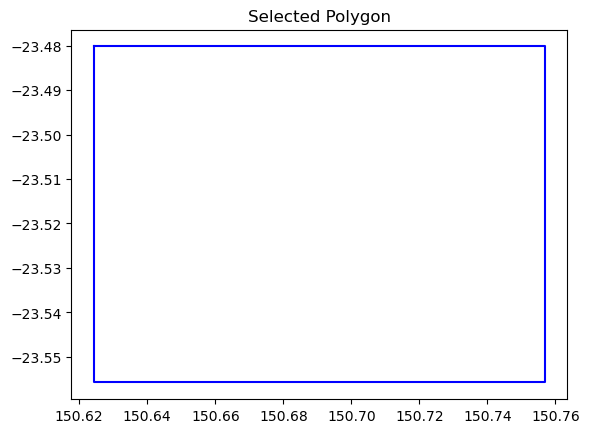

Section 3: Display Selected Coordinates - Completed


In [7]:
import matplotlib.pyplot as plt
from pyproj import Proj
from shapely.geometry.polygon import LinearRing
import gc

# Function to convert latitude and longitude to UTM coordinates
def latlon_to_utm(lat, lon):
    utm_proj = Proj(proj="utm", zone=33, datum="WGS84")  # Change zone as needed
    utm_x, utm_y = utm_proj(lon, lat)
    return utm_x, utm_y

# Function to display the selected coordinates, UTM coordinates, and visualize the polygon
def display_selected_coordinates(selected_polygon):
    if selected_polygon is not None:
        coords = selected_polygon.exterior.coords
        utm_coords = [latlon_to_utm(lat, lon) for lon, lat in coords]

        print("The drawn shape was used for selection.")
        print("The geopolygon of interest is the following one; ")
        print(selected_polygon)

        print("\nSelected Polygon Coordinates:")
        for lon, lat in coords:
            print(f"Latitude: {lat}, Longitude: {lon}")

        print("\nUTM Coordinates:")
        for utm_x, utm_y in utm_coords:
            print(f"UTM X: {utm_x}, UTM Y: {utm_y}")

        # Visualize the selected polygon
        ring = LinearRing(coords)
        fig, ax = plt.subplots()
        ax.plot(*ring.xy, color="blue")
        ax.set_title("Selected Polygon")
        plt.show()
        
        # Explicitly clear variables and run garbage collection
        del coords, utm_coords, ring, fig, ax
        gc.collect()
    else:
        print("No polygon selected")

# Call the function to display the coordinates and visualize the polygon
# Assuming you have the selected polygon stored in a variable named 'selected_polygon'
display_selected_coordinates(selected_polygon)

print("Section 3: Display Selected Coordinates - Completed")


# Section 4 - Date Selection

In [8]:
from datetime import datetime
from IPython.display import display
from ipywidgets import widgets
import gc

# Define a function to update and print the time range
def update_time_range(start_date, end_date):
    time_range = (start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
#    print(f"Selected time range: {time_range}")
    return time_range

# Input widgets for specifying the year range
start_date_input = widgets.DatePicker(
    description="Start Date", value=datetime(2010, 1, 1)  # Default value (example)
)

end_date_input = widgets.DatePicker(
    description="End Date", value=datetime(2020, 12, 31)  # Default value (example)
)

# Display date pickers
display(start_date_input, end_date_input)

# Attach the update function to the date pickers
def on_date_change(change):
    update_time_range(start_date_input.value, end_date_input.value)

start_date_input.observe(on_date_change, names='value')
end_date_input.observe(on_date_change, names='value')

# Initial call to set the time range
time_range = update_time_range(start_date_input.value, end_date_input.value)

# Free up memory if necessary
_ = gc.collect()  # Store the result in a variable to avoid displaying it


DatePicker(value=datetime.datetime(2010, 1, 1, 0, 0), description='Start Date', step=1)

DatePicker(value=datetime.datetime(2020, 12, 31, 0, 0), description='End Date', step=1)

In [9]:
print(f"Selected time range: {time_range}")

Selected time range: ('2010-01-01', '2020-12-31')


# Section 5 - DEA Data Load

In [10]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from ipywidgets import HTML, VBox
from IPython.display import display
import time
import logging
import threading
import gc

# Suppress garbage collection warnings
logging.getLogger("distributed.utils_perf").setLevel(logging.ERROR)

# Create a dot indicator
spinner = HTML("<b>.</b>")
box = VBox([spinner])
display(box)

# Function to update the spinner
def spin():
    while not done:
        spinner.value = spinner.value + "." if len(spinner.value) < 10 else "<b>.</b>"
        time.sleep(0.5)

# Assume total steps is the number of files/jobs being loaded
total_steps = 10  # Replace with the actual number of steps

# Ensure actual data loading for DEA Land Cover data
done = False
try:
    # Start the spinner in a separate thread
    spinner_thread = threading.Thread(target=spin)
    spinner_thread.start()
    
    # Step 1: Check if required variables are defined
    if lat_range is None or lon_range is None or start_date_input.value is None or end_date_input.value is None:
        raise ValueError("Latitude, Longitude, or Time range is not defined")

    print("Lat Range:", lat_range)
    print("Lon Range:", lon_range)
    print("Start Date:", start_date_input.value)
    print("End Date:", end_date_input.value)

    # Step 2: Construct the query
    query = {
        "y": lat_range,
        "x": lon_range,
        "time": (start_date_input.value, end_date_input.value),
    }

    print("Query Parameters:", query)

    # Step 3: Load DEA Land Cover data from the datacube
    with tqdm(total=total_steps, desc="Loading DEA Land Cover data", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]') as pbar:
        lc = dc.load(
            product="ga_ls_landcover_class_cyear_2",
            output_crs="EPSG:3577",
            measurements=[
                "level3",
                "lifeform",
                "vegetation_cover",
                "water_seasonality",
                "water_state",
                "intertidal",
                "water_persistence",
                "bare_gradation",
                "full_classification",
            ],
            resolution=(-25, 25),
#            dask_chunks={'time': 1},
            **query
        ).persist()
        
        # Update the progress bar after each step
        pbar.update(1)  # Adjust the value if multiple steps are combined into one

        # Simulate further steps if necessary
        for _ in range(total_steps - 1):
            time.sleep(0.1)  # Simulate a step taking time
            pbar.update(1)

    pbar.close()  # Close the progress bar to remove it from the output
    print("DEA Land Cover data loaded successfully.")
except Exception as e:
    print(f"Error loading DEA Land Cover data: {e}")
finally:
    # Stop the spinner
    done = True
    spinner_thread.join()

# Remove the spinner
box.close()

# Step 4: Check if the dataset is loaded correctly
if 'lc' not in locals() or lc is None or lc.geobox is None:
    raise ValueError("Failed to load the dataset. Please check the query parameters and ensure data is available for the specified region and time range.")   

# Step 5: Print geobox information
geobox = lc.geobox

geobox_info = f"""
Geobox Information:
-------------------
CRS: {geobox.crs}
Dimensions: {geobox.dimensions}
Resolution: {geobox.resolution}
Shape: {geobox.shape}
Extent: {geobox.extent}
"""

print(geobox_info)

# Step 6: Check loaded data dimensions and variables
print("Loaded data dimensions:", lc.dims)
print("Loaded data variables:", lc.data_vars)

# Free up memory if necessary
_ = gc.collect()  # Suppress the output by assigning it to a variable


Lat Range: (-23.555780636311454, -23.48017385804056)
Lon Range: (150.62426241661194, 150.7568309014493)
Start Date: 2010-01-01 00:00:00
End Date: 2020-12-31 00:00:00
Query Parameters: {'y': (-23.555780636311454, -23.48017385804056), 'x': (150.62426241661194, 150.7568309014493), 'time': (datetime.datetime(2010, 1, 1, 0, 0), datetime.datetime(2020, 12, 31, 0, 0))}


Loading DEA Land Cover data:   0%|          | 0/10 [00:00<?]

DEA Land Cover data loaded successfully.

Geobox Information:
-------------------
CRS: PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3577"]]
Dimensions: ('y', 'x')
Resolution: (-25.0, 25.0)
Shape: (414, 580)
Extent: Geometry({'type': 'Polygon', 'coordinates': (((1875550.0, -2669425.0), (1875550.0, -2679775.0), (1890050.0, -2679775.0), (1890050.0, -2669425.0), (1875550.0, -2669425

# Section 6 - Checkbox Plots

In [11]:
# Section 6: Checkbox widgets for selecting datasets
def create_checkbox(description, initial_value=False):
    return Checkbox(description=description, value=initial_value)

level3_checkbox = create_checkbox('Level 3')
lifeform_checkbox = create_checkbox('Lifeform')
vegetation_cover_checkbox = create_checkbox('Vegetation Cover')
water_state_checkbox = create_checkbox('Water State')
water_persistence_checkbox = create_checkbox('Water Persistence')
full_classification_checkbox = create_checkbox('Full Classification')
item_checkbox = create_checkbox('Intertidal Elevation')

output = Output()

def plot_land_cover_dataset(dataset, title):
    plt.figure()
    plot_land_cover(dataset)
    plt.title(title)
    plt.show()

def plot_selected_datasets():
    with output:
        output.clear_output()
        selected_datasets = {
            'Level 3': (level3_checkbox.value, lc.level3 if 'lc' in globals() else None),
            'Lifeform': (lifeform_checkbox.value, lc.lifeform if 'lc' in globals() else None),
            'Vegetation Cover': (vegetation_cover_checkbox.value, lc.vegetation_cover if 'lc' in globals() else None),
            'Water State': (water_state_checkbox.value, lc.water_state if 'lc' in globals() else None),
            'Water Persistence': (water_persistence_checkbox.value, lc.water_persistence if 'lc' in globals() else None),
            'Full Classification': (full_classification_checkbox.value, lc.full_classification if 'lc' in globals() else None),
            'Intertidal Elevation': (item_checkbox.value, item.elevation[0] if 'item' in globals() else None)
        }

        for title, (is_selected, dataset) in selected_datasets.items():
            if is_selected and dataset is not None:
                plot_land_cover_dataset(dataset, title)
                del dataset  # Free up memory

plot_datasets_button = Button(description='Plot Selected Data')
plot_datasets_button.on_click(lambda b: plot_selected_datasets())

checkboxes_box = HBox([
    level3_checkbox, 
    lifeform_checkbox, 
    vegetation_cover_checkbox, 
    water_state_checkbox, 
    water_persistence_checkbox, 
    full_classification_checkbox,
    item_checkbox
])
display(checkboxes_box)
display(plot_datasets_button)
display(output)


Button(description='Plot Selected Data', style=ButtonStyle())

Output()

In [ ]:
## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)

In [ ]:
**Tags**: :index:`sandbox compatible`, :index:`landsat 5`, :index:`landsat 7`, :index:`landsat 8`, 
:index:`DEA Land Cover`, :index:`time series`, :index: `LCCS`, :index:`colour maps`, :index:`data visualisation`